In [3]:
import numpy as np
import matplotlib.pyplot as  plt
import scipy.stats as stats
import scipy.linalg
from scipy.integrate import solve_ivp
import ot

In [4]:
def compute_gradient_U(X_samples, mu_X, Sigma_X):
    
    # Inverse of the covariance matrix
    Sigma_X_inv = np.linalg.inv(Sigma_X)
    
    # Compute the gradient for each sample
    gradients = np.dot(X_samples - mu_X, Sigma_X_inv)
    
    return gradients

# EM scheme with conditional expectation estimation (d=2)

(10000, 2, 501)
325.24350168042304
squared 2‑Wasserstein (Bures) distance = 325.53589838486226
 |E‖X_T−Y_T‖² – W₂²| = 0.4230898958988405


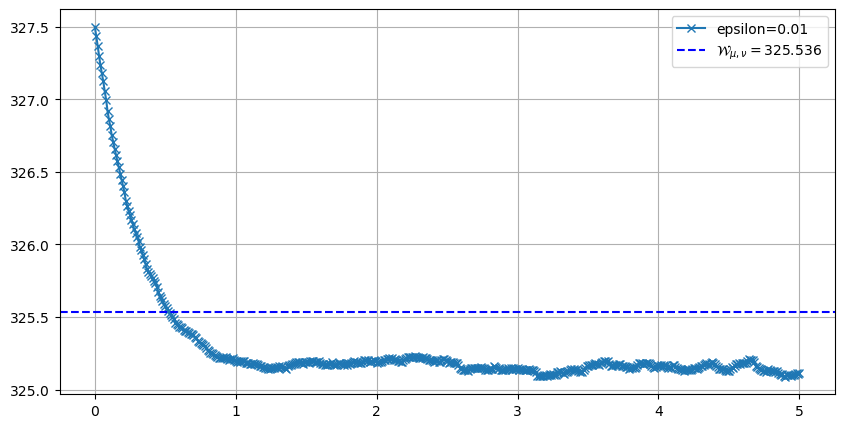

In [6]:
from cond_expect_ols import compute_ols_parameters, compute_conditional_mean, compute_relative_L2_error

# Set random seed for reproducibility
np.random.seed(56)

# Define parameters
num_samples = 10000
epsilon = 0.01
T = 5
d = 2

# Define parameters for X and Y
mu_X = np.array([10, 20])  # Mean of X
mu_Y = np.array([4, 3])  # Mean of Y
K_XX = np.array([[1, 0.5], [0.5, 1]])  # Covariance matrix for X
K_YY = np.array([[1, -0.5], [-0.5, 1]])  # Covariance matrix for Y
K_XY = np.array([[0.3, 0.2], [0.2, 0.3]])  # Covariance matrix between X and Y

# Generate samples from the joint distribution
mu = np.concatenate([mu_X, mu_Y])
Sigma = np.block([
    [K_XX, K_XY],
    [K_XY.T, K_YY]
])
samples = np.random.multivariate_normal(mu, Sigma, size=num_samples)

# Split the samples into X and Y
X = samples[:, :2]
Y = samples[:, 2:]

N = 500
X_traj = np.zeros((num_samples, d, N+1))
Y_traj = np.zeros((num_samples, d, N+1))
X_traj[:, :, 0] = X
Y_traj[:, :, 0] = Y

Dt = T/N

# Brownian increments for X1 and X2
W_inc = np.sqrt(Dt * 2 * epsilon) * np.random.normal(0, 1, (num_samples, d, N)) 
# Cumulative sum to get the Brownian motion paths
W = np.concatenate((np.zeros((num_samples, d, 1)), np.cumsum(W_inc, axis=2)), axis=2)
print(W.shape)

# Brownian increments for Y1 and Y2
B_inc = np.sqrt(Dt * 2 * epsilon) * np.random.normal(0, 1, (num_samples, d, N))
# Cumulative sum to get the Brownian motion paths
B = np.concatenate((np.zeros((num_samples, d, 1)), np.cumsum(B_inc, axis=2)), axis=2)
errors = np.zeros(N+1)
errors[0] = np.mean(np.sum((X - Y)**2, axis=1))

for n in range(N):
    cond_meanYX, _, _ = compute_ols_parameters(X_traj[:,:,n], Y_traj[:,:,n])
    cond_meanXY, _, _ = compute_ols_parameters(Y_traj[:,:,n], X_traj[:,:,n])
    gradU = compute_gradient_U(X_traj[:,:,n], mu_X, K_XX)
    gradV = compute_gradient_U(Y_traj[:,:,n], mu_Y, K_YY)
    
    # dW = W[:,:,n+1] - W[:,:,n]
    # dB = B[:,:,n+1] - B[:,:,n]

    X_traj[:,:,n+1] = X_traj[:,:,n] + (Y_traj[:,:,n] - cond_meanYX - epsilon*gradU)*Dt + W_inc[:,:,n]
    Y_traj[:,:,n+1] = Y_traj[:,:,n] + (X_traj[:,:,n] - cond_meanXY - epsilon*gradV)*Dt + B_inc[:,:,n]
    errors[n+1] = np.mean(np.sum((X_traj[:,:,n+1] - Y_traj[:,:,n+1])**2, axis=1))
iters  = np.linspace(0, T, N+1)

# recover the squared Gaussian Bures-Wasserstein distance
res = ot.solve_sample(X, Y, method='gaussian')
BW_dist = res.value
print(BW_dist)
# --- after the loop finishes ----------------------------------------------
# squared Bures–Wasserstein distance (closed form, independent of your samples)
def gaussian_w2_squared(mu1, Sigma1, mu2, Sigma2):
    """W2²( N(mu1,Sigma1), N(mu2,Sigma2) )."""
    diff2 = np.dot(mu1 - mu2, mu1 - mu2)           # ‖μ₁ − μ₂‖²
    S1_half   = scipy.linalg.sqrtm(Sigma1)
    inner     = S1_half @ Sigma2 @ S1_half
    cross     = scipy.linalg.sqrtm(inner)
    trace_part = np.trace(Sigma1 + Sigma2 - 2 * cross)
    return diff2 + trace_part

BW_dist = gaussian_w2_squared(mu_X, K_XX, mu_Y, K_YY)   # this is already *squared*
print("squared 2‑Wasserstein (Bures) distance =", BW_dist)

# discrepancy between the simulation at time T and the exact value
print(" |E‖X_T−Y_T‖² – W₂²| =", abs(errors[-1] - BW_dist))

plt.figure(figsize=(10, 5))
plt.plot(iters, errors, linestyle='-', marker='x', label=f'epsilon={epsilon}')
plt.axhline(y=BW_dist, color='blue', linestyle='--', label=fr'$\mathcal{{W}}_{{\mu, \nu}} = {BW_dist:.3f}$')

plt.savefig('2D_Gaussian_with_cond_expectation.png', dpi=300, bbox_inches='tight')
plt.legend()
plt.grid()
plt.show()

In [5]:

fhat, coefs, A = compute_ols_parameters(X, Y)
cond_mean = compute_conditional_mean(X, mu_X, mu_Y, K_XX, K_XY)
L2_error = compute_relative_L2_error(fhat, cond_mean)
print(L2_error)

0.0066438929562507775
